In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from sklearn.manifold import TSNE

In [ ]:
latent_dim = 64
num_epochs = 2

In [3]:
class SIRENLayer(nn.Module):
    """
    SIREN Layer:
    - Uses sine as the activation function.
    - Applies specific weight initialization rules for SIREN.
    """
    def __init__(self, in_features, out_features, omega_0=30.0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.linear = nn.Linear(in_features, out_features)
        self.is_first = is_first
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                # Special initialization for the first layer
                self.linear.weight.uniform_(-1 / self.linear.in_features, 1 / self.linear.in_features)
            else:
                # General initialization for subsequent layers
                self.linear.weight.uniform_(-torch.sqrt(torch.tensor(6.0 / self.linear.in_features)) / self.omega_0, 
                                             torch.sqrt(torch.tensor(6.0 / self.linear.in_features)) / self.omega_0)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))


class Clamp(nn.Module):
    def __init__(self, min_val=0.0, max_val=1.0):
        super(Clamp, self).__init__()
        self.min_val = min_val
        self.max_val = max_val
    
    def forward(self, x):
        return torch.clamp(x, min=self.min_val, max=self.max_val)


class ScaledSigmoid(nn.Module):
    """
    Custom activation function: Scaled Sigmoid
    Output range: [-1, 1]
    """
    def forward(self, x):
        return 2 * torch.sigmoid(x) - 1


# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 768),
            nn.LeakyReLU(),
            nn.Linear(768, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
        )
        self.fc_mu = nn.Linear(128, latent_dim)  # Mean of latent space
        self.fc_log_var = nn.Linear(128, latent_dim)  # Log-variance of latent space

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 768),
            nn.LeakyReLU(),
            nn.Linear(768, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)  # Sample epsilon from standard normal
        return mu + eps * std

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)

        # Reparameterize
        z = self.reparameterize(mu, log_var)

        # Decode
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var


# Loss function (Reconstruction + KL Divergence)
def vae_loss(reconstructed, original, mu, log_var):
    # Reconstruction loss
    recon_loss = nn.MSELoss(reduction='sum')(reconstructed, original)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kl_loss

In [ ]:
# Define a transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),               # Convert input to tensor in [0, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Model, optimizer, and training setup
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0007)

In [34]:
num_epochs = 2
optimizer = optim.Adam(model.parameters(), lr=0.0007)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.view(images.size(0), -1)

        # Forward pass
        reconstructed, mu, log_var = model(images)
        loss = vae_loss(reconstructed, images, mu, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.2f}")

Epoch [1/2], Loss: 2094184.24
Epoch [2/2], Loss: 2082177.49


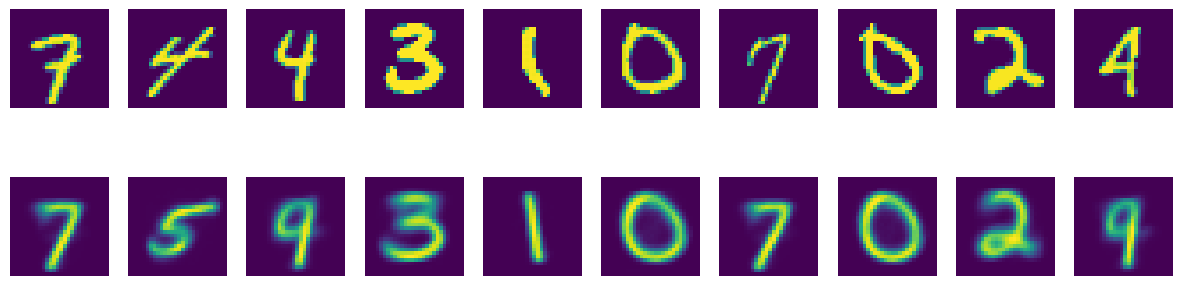

In [35]:
# Visualize reconstructions
model.eval()
test_loader = data.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_images, _ = next(iter(test_loader))
test_images_flat = test_images.view(test_images.size(0), -1)

with torch.no_grad():
    reconstructed, _, _ = model(test_images_flat)

# Reshape for visualization
test_images = test_images.numpy()
reconstructed = reconstructed.view(-1, 1, 28, 28).numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    # Original images
    axes[0, i].imshow(test_images[i][0])
    axes[0, i].axis('off')
    # Reconstructed images
    axes[1, i].imshow(reconstructed[i][0])
    axes[1, i].axis('off')
plt.show()

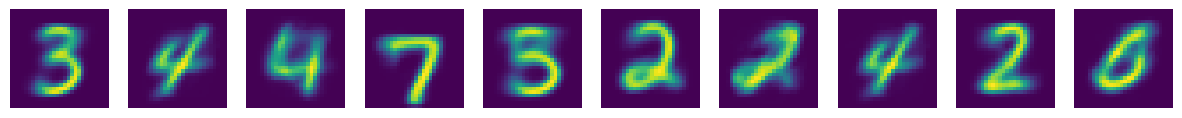

In [27]:
# Random latent gen
with torch.no_grad():
    z = torch.randn(10, model.fc_mu.out_features)  # Random latent vectors
    generated = model.decoder(z).view(-1, 1, 28, 28).numpy()

# Plot generated images
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(generated[i][0])
    axes[i].axis('off')
plt.show()

In [28]:
# Get latent space representation
model.eval()
latents = []
labels = []

with torch.no_grad():
    for images, label in train_loader:
        images = images.view(images.size(0), -1)
        _, mu, _ = model(images)
        latents.append(mu)
        labels.append(label)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

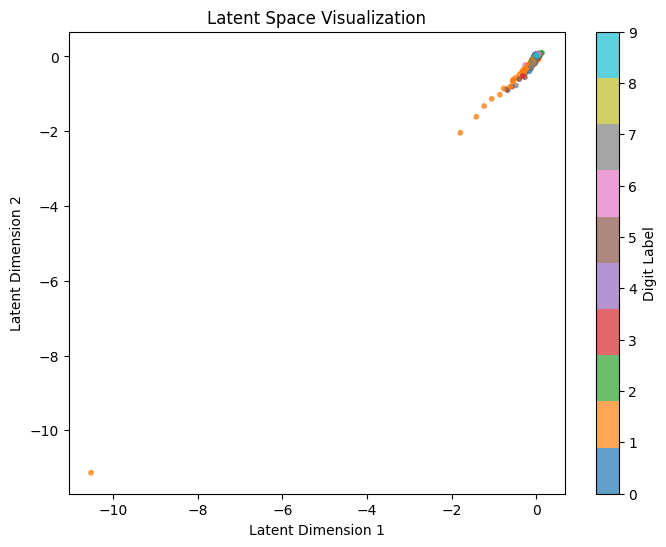

In [29]:
# Latent space 2D vis

# Ensure the latent dimension is 2 for visualization
# assert model.fc_mu.out_features == 2, "Latent dimension must be 2 for 2D visualization!"

# Plot the latent space
plt.figure(figsize=(8, 6))

scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)

plt.colorbar(scatter, label="Digit Label")
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

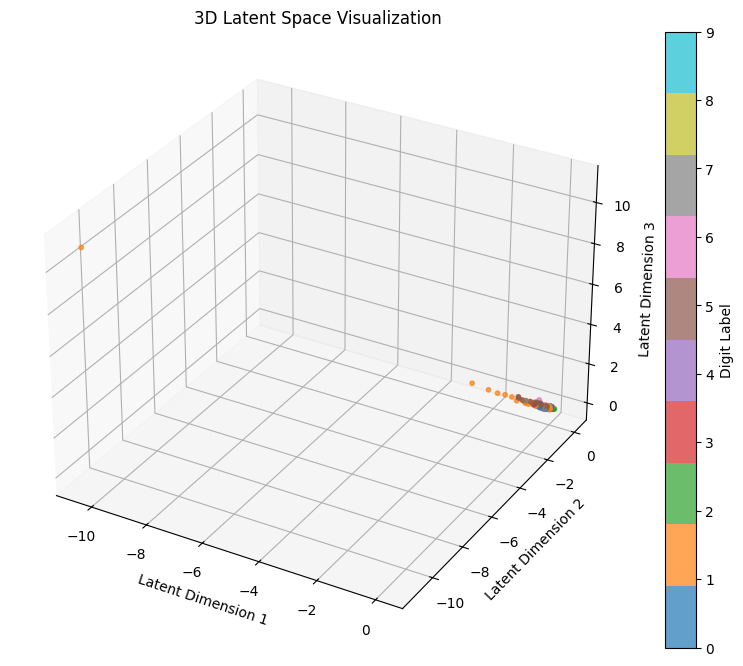

In [30]:
# Latent space 3D vis

# Ensure the latent dimension is 3 for visualization
# assert model.fc_mu.out_features == 3, "Latent dimension must be 3 for 3D visualization!"

# Plot the 3D latent space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(latents[:, 0], latents[:, 1], latents[:, 2], c=labels, cmap='tab10', s=10, alpha=0.7)

fig.colorbar(scatter, ax=ax, label="Digit Label")
ax.set_title("3D Latent Space Visualization")
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")

plt.show()

In [31]:
# take k samples of latents to speed up t-SNE
k = 4000  
indices = torch.randperm(latents.shape[0])[:k]
sampled_latents = latents[indices]
sampled_labels = labels[indices]

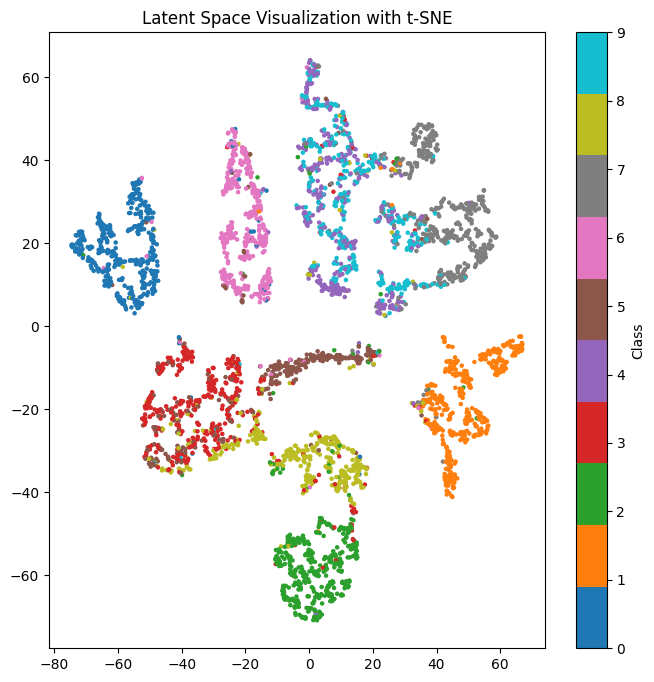

In [32]:
# Perform t-SNE on latent vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d_tsne = tsne.fit_transform(sampled_latents)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))

scatter = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=sampled_labels, cmap='tab10', s=5)

plt.colorbar(scatter, label="Class")
plt.title("Latent Space Visualization with t-SNE")
plt.show()

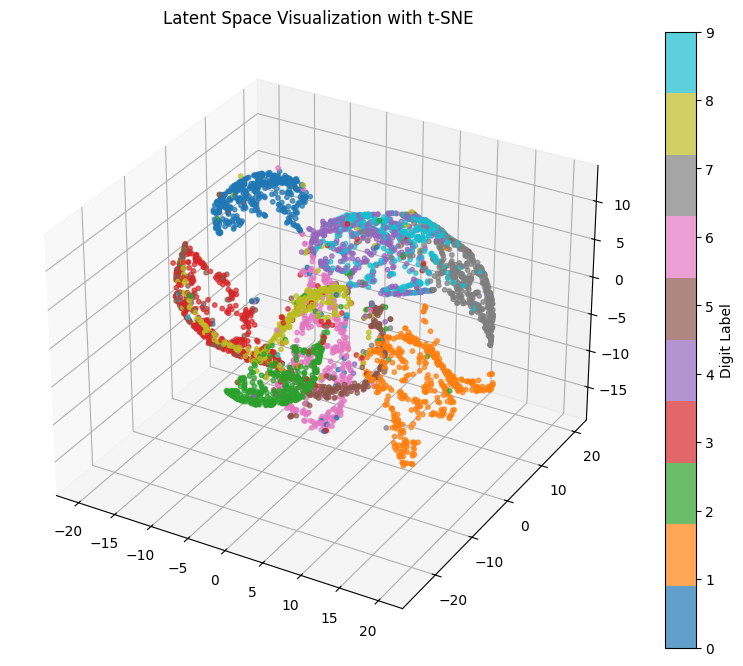

In [33]:
# Perform t-SNE on latent vectors
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
latent_3d_tsne = tsne.fit_transform(sampled_latents)

# Plot the 3D latent space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(latent_3d_tsne[:, 0], latent_3d_tsne[:, 1], latent_3d_tsne[:, 2], c=sampled_labels, cmap='tab10', s=10, alpha=0.7)

fig.colorbar(scatter, ax=ax, label="Digit Label")
ax.set_title("Latent Space Visualization with t-SNE")

plt.show()